In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import euclidean
import pickle

In [2]:
df = pd.read_csv('Walmart.csv')
print(df.head())
print(f"Dataset Shape: {df.shape}")

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
Dataset Shape: (6435, 8)


# Data Preprocessing

In [5]:
data = df.copy()
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Sort by store and date
data = data.sort_values(['Store', 'Date'])

# Feature Engineering for Anomaly Detection
print("\nCreating features for anomaly detection...")

# Time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data['Quarter'] = data['Date'].dt.quarter
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Sales-based features
data['Sales_Lag1'] = data.groupby('Store')['Weekly_Sales'].shift(1)
data['Sales_Lag2'] = data.groupby('Store')['Weekly_Sales'].shift(2)

# Rolling statistics (detect sudden changes)
data['Sales_RollingMean_4'] = data.groupby('Store')['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)
data['Sales_RollingStd_4'] = data.groupby('Store')['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).std()
)

# Deviation from rolling mean (key anomaly indicator!)
data['Sales_Deviation'] = (data['Weekly_Sales'] - data['Sales_RollingMean_4']) / (data['Sales_RollingStd_4'] + 1)

# Week-over-week change
data['Sales_WoW_Change'] = data.groupby('Store')['Weekly_Sales'].pct_change()

# Z-score (statistical anomaly measure)
data['Sales_ZScore'] = data.groupby('Store')['Weekly_Sales'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-8)
)

# Remove NaN values
data = data.dropna()

print(f"Features created. Dataset shape: {data.shape}")
print(f"Key anomaly indicators: Sales_Deviation, Sales_WoW_Change, Sales_ZScore")

print("\nSales Statistics:")
print(data['Weekly_Sales'].describe())


Creating features for anomaly detection...
Features created. Dataset shape: (6345, 20)
Key anomaly indicators: Sales_Deviation, Sales_WoW_Change, Sales_ZScore

Sales Statistics:
count    6.345000e+03
mean     1.046356e+06
std      5.639788e+05
min      2.099862e+05
25%      5.538370e+05
50%      9.593395e+05
75%      1.419237e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64


# Exploratory Data Analysis (EDA)

EDA visualizations saved as 'anomaly_eda.png'


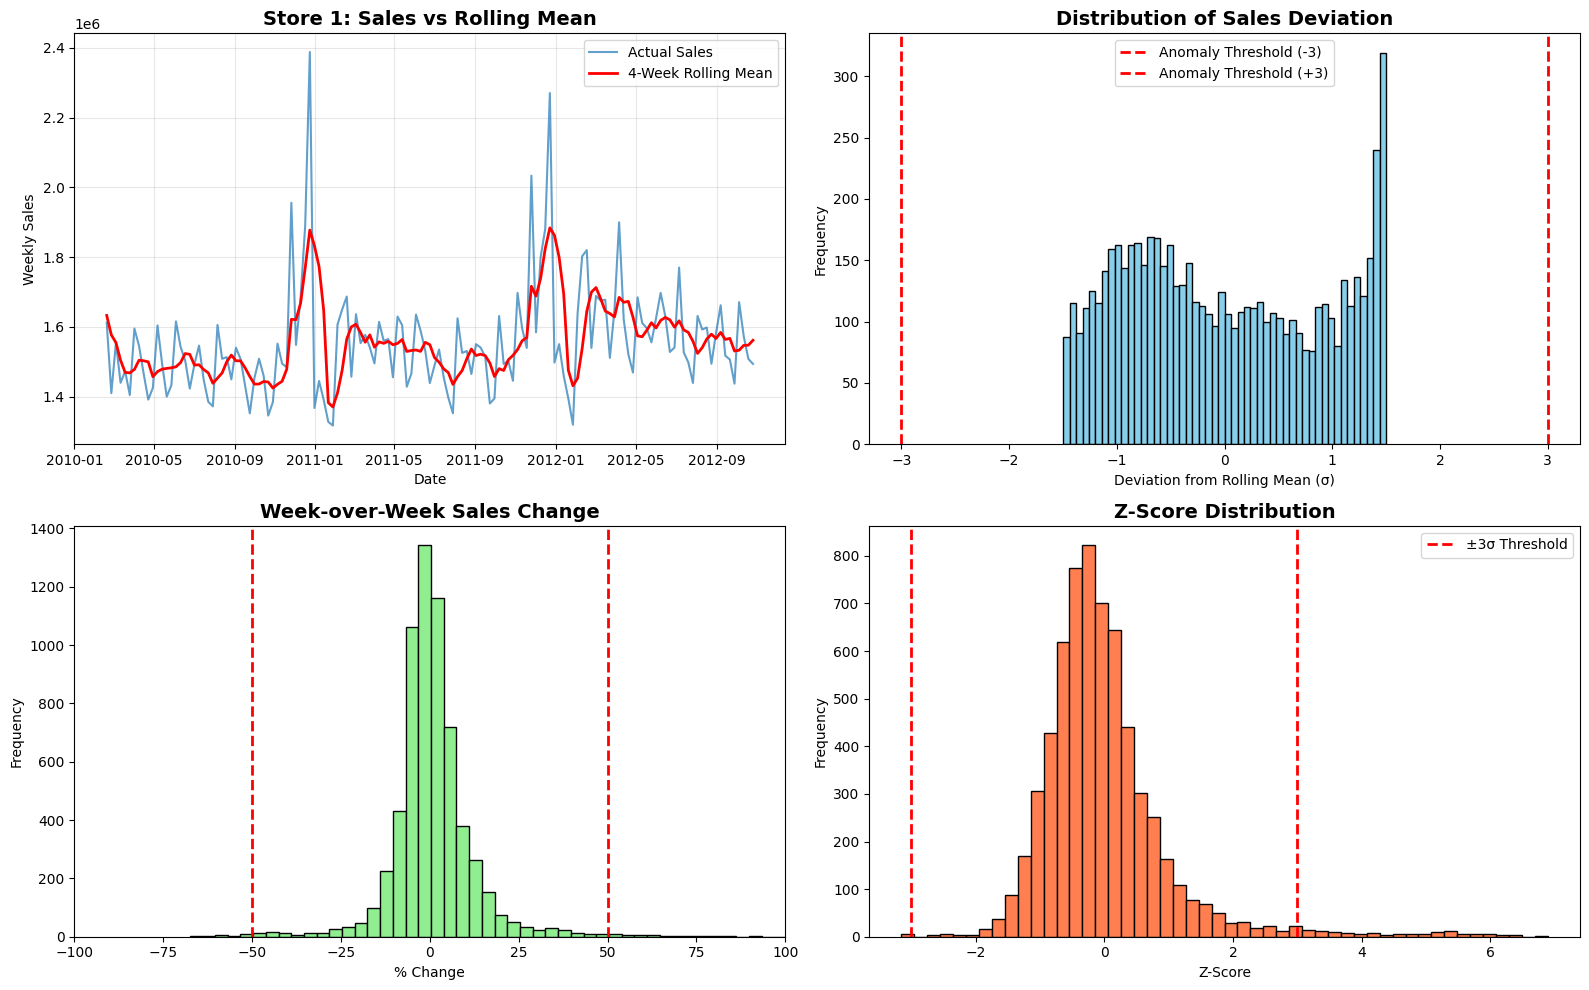

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Sales over time with rolling mean
sample_store = data['Store'].iloc[0]
store_data = data[data['Store'] == sample_store].copy()
axes[0, 0].plot(store_data['Date'], store_data['Weekly_Sales'], label='Actual Sales', alpha=0.7)
axes[0, 0].plot(store_data['Date'], store_data['Sales_RollingMean_4'], 
                label='4-Week Rolling Mean', color='red', linewidth=2)
axes[0, 0].set_title(f'Store {sample_store}: Sales vs Rolling Mean', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Weekly Sales')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 3. Week-over-Week Change Distribution
axes[1, 0].hist(data['Sales_WoW_Change'].dropna() * 100, bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(x=-50, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=50, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Week-over-Week Sales Change', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('% Change')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(-100, 100)

# 4. Z-Score Distribution
axes[1, 1].hist(data['Sales_ZScore'], bins=50, color='coral', edgecolor='black')
axes[1, 1].axvline(x=-3, color='red', linestyle='--', linewidth=2, label='±3σ Threshold')
axes[1, 1].axvline(x=3, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Z-Score Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Z-Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('anomaly_eda.png', dpi=300, bbox_inches='tight')
print("EDA visualizations saved as 'anomaly_eda.png'")
plt.show()


# K-MEANS Clustering


Finding optimal number of clusters...
Elbow curve saved as 'kmeans_elbow.png'


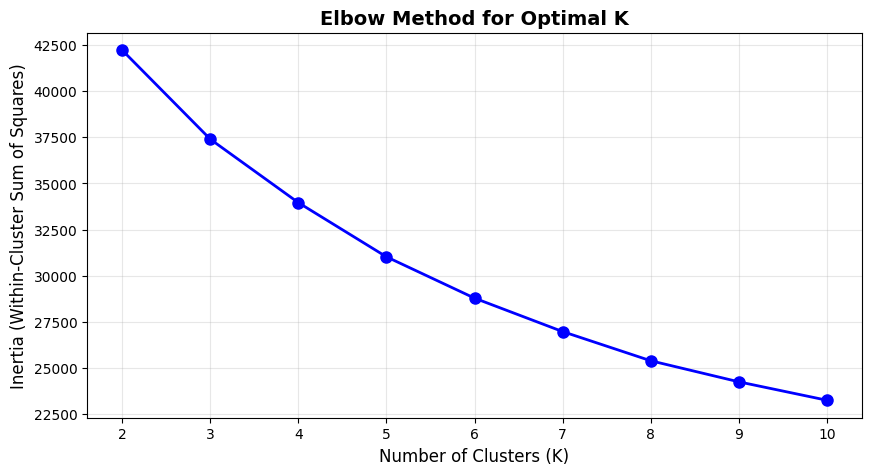

In [8]:
kmeans_features = [
    'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Sales_Deviation', 'Sales_WoW_Change', 'Sales_ZScore'
]

X_kmeans = data[kmeans_features].copy()

# Scale features (important for K-Means!)
scaler_kmeans = StandardScaler()
X_kmeans_scaled = scaler_kmeans.fit_transform(X_kmeans)

# Find optimal number of clusters using Elbow Method
print("\nFinding optimal number of clusters...")
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_kmeans_scaled)
    inertias.append(kmeans_temp.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.savefig('kmeans_elbow.png', dpi=300, bbox_inches='tight')
print("Elbow curve saved as 'kmeans_elbow.png'")
plt.show()

In [9]:
optimal_k = 4
print(f"\nTraining K-Means with K={optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['KMeans_Cluster'] = kmeans.fit_predict(X_kmeans_scaled)

# Calculate distance from cluster center (anomaly score)
data['KMeans_Distance'] = np.min(
    np.linalg.norm(X_kmeans_scaled[:, np.newaxis] - kmeans.cluster_centers_, axis=2),
    axis=1
)

# Define anomalies as points far from any cluster center
kmeans_threshold = np.percentile(data['KMeans_Distance'], 95)  # Top 5% as anomalies
data['KMeans_Anomaly'] = (data['KMeans_Distance'] > kmeans_threshold).astype(int)

print(f"K-Means clustering complete")
print(f"Anomaly threshold: {kmeans_threshold:.4f}")
print(f"Anomalies detected: {data['KMeans_Anomaly'].sum()} out of {len(data)} ({data['KMeans_Anomaly'].sum()/len(data)*100:.2f}%)")


Training K-Means with K=4 clusters...
K-Means clustering complete
Anomaly threshold: 3.3903
Anomalies detected: 318 out of 6345 (5.01%)


K-Means visualizations saved as 'kmeans_anomalies.png'


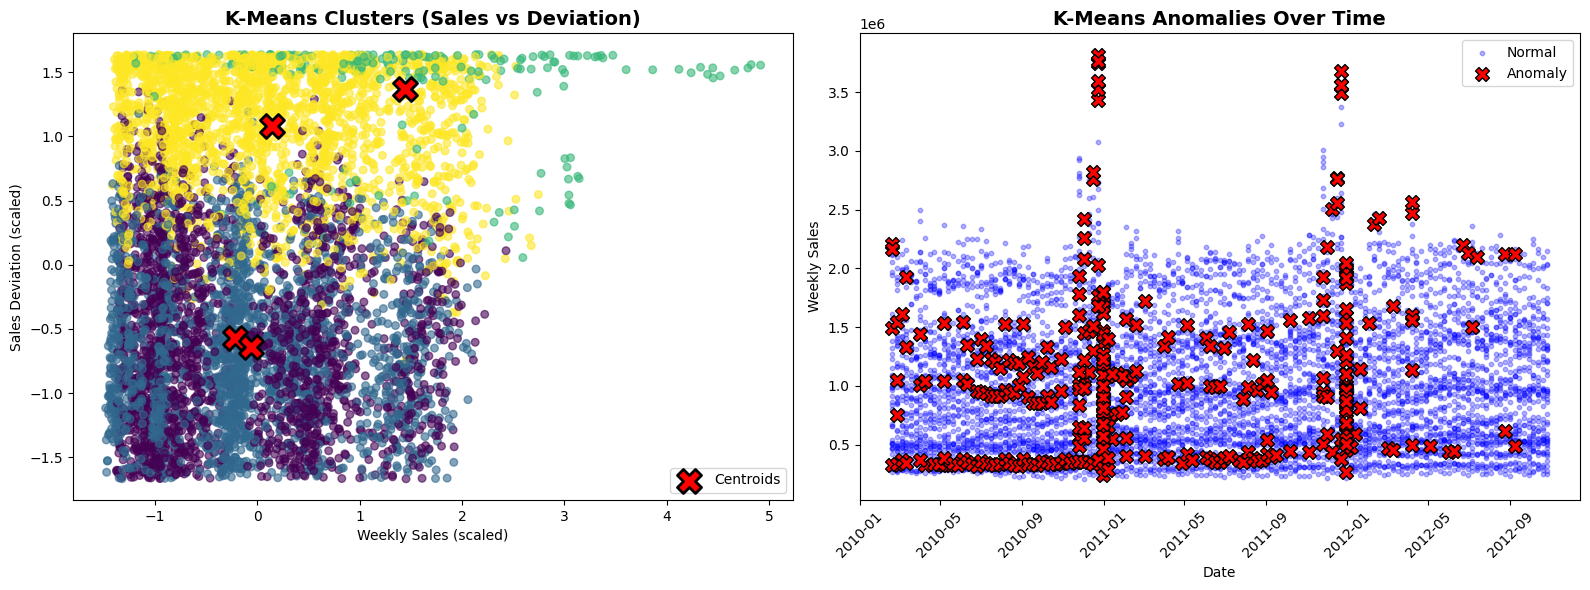

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster visualization (2D projection)
axes[0].scatter(X_kmeans_scaled[:, 0], X_kmeans_scaled[:, 5], 
                c=data['KMeans_Cluster'], cmap='viridis', alpha=0.6, s=30)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 5],
                c='red', marker='X', s=300, edgecolors='black', linewidths=2, label='Centroids')
axes[0].set_title('K-Means Clusters (Sales vs Deviation)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Weekly Sales (scaled)')
axes[0].set_ylabel('Sales Deviation (scaled)')
axes[0].legend()

# Anomalies over time
anomaly_data = data[data['KMeans_Anomaly'] == 1]
axes[1].scatter(data['Date'], data['Weekly_Sales'], alpha=0.3, s=10, label='Normal', color='blue')
axes[1].scatter(anomaly_data['Date'], anomaly_data['Weekly_Sales'], 
                color='red', s=100, marker='X', label='Anomaly', edgecolors='black', linewidths=1)
axes[1].set_title('K-Means Anomalies Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weekly Sales')
axes[1].legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('kmeans_anomalies.png', dpi=300, bbox_inches='tight')
print("K-Means visualizations saved as 'kmeans_anomalies.png'")
plt.show()

# Hierarchical Clustering

Performing hierarchical clustering...
Sampled 1000 points for visualization

Dendrogram saved as 'hierarchical_dendrogram.png'


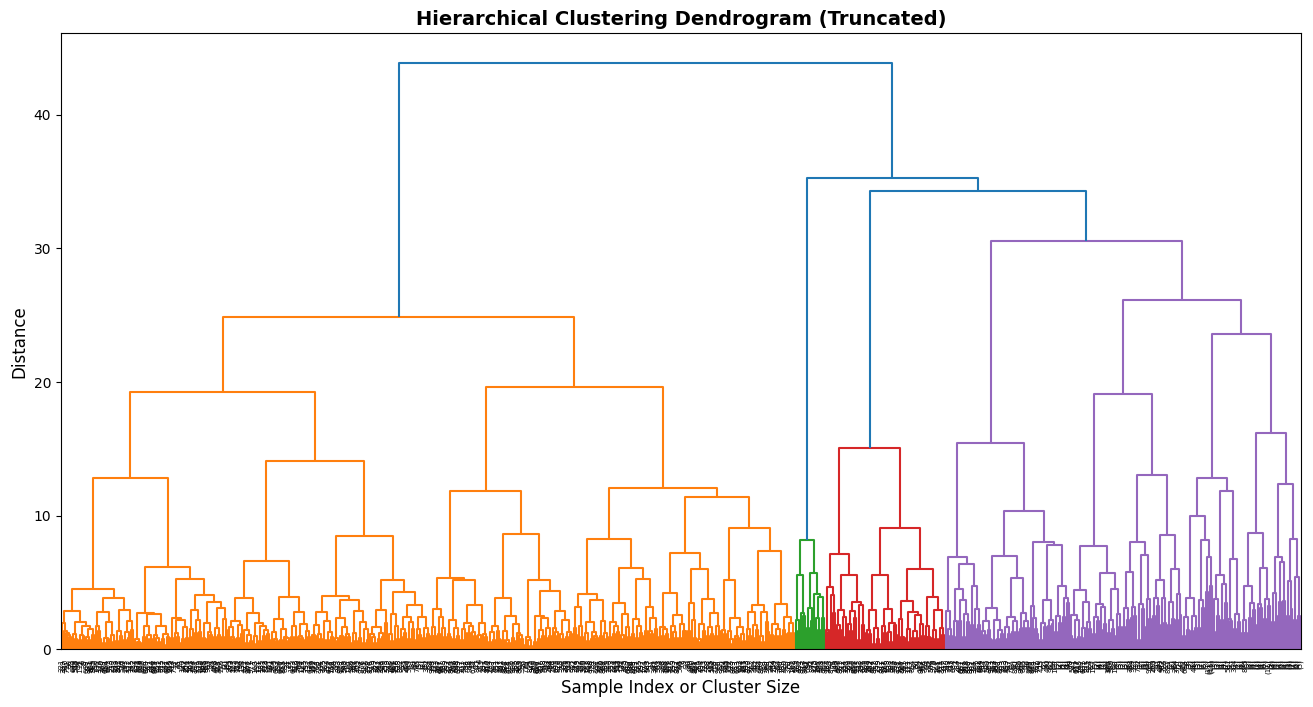

In [11]:
print("Performing hierarchical clustering...")

# For performance, sample data if dataset is large
if len(data) > 1000:
    sample_indices = np.random.choice(len(data), 1000, replace=False)
    X_hierarchical = X_kmeans_scaled[sample_indices]
    print(f"Sampled {len(sample_indices)} points for visualization")
else:
    X_hierarchical = X_kmeans_scaled
    sample_indices = range(len(data))

# Perform hierarchical clustering
linkage_matrix = linkage(X_hierarchical, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram (Truncated)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.savefig('hierarchical_dendrogram.png', dpi=300, bbox_inches='tight')
print("\nDendrogram saved as 'hierarchical_dendrogram.png'")
plt.show()

In [13]:
n_clusters = 4
hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Assign labels back to data
data_copy = data.copy()
data_copy['Hierarchical_Cluster'] = -1
data_copy.iloc[sample_indices, data_copy.columns.get_loc('Hierarchical_Cluster')] = hierarchical_labels

# Identify anomalies (small clusters or far from centers)
cluster_sizes = pd.Series(hierarchical_labels).value_counts()
small_clusters = cluster_sizes[cluster_sizes < len(hierarchical_labels) * 0.1].index
data_copy['Hierarchical_Anomaly'] = data_copy['Hierarchical_Cluster'].isin(small_clusters).astype(int)

print(f"Hierarchical clustering complete")
print(f"Number of clusters: {n_clusters}")
print(f"Anomalies detected: {data_copy['Hierarchical_Anomaly'].sum()} out of {len(data_copy)} ({data_copy['Hierarchical_Anomaly'].sum()/len(data_copy)*100:.2f}%)")

# Update main dataframe
data['Hierarchical_Cluster'] = data_copy['Hierarchical_Cluster']
data['Hierarchical_Anomaly'] = data_copy['Hierarchical_Anomaly']

Hierarchical clustering complete
Number of clusters: 4
Anomalies detected: 82 out of 6345 (1.29%)


# Isolation Forest

In [14]:
isolation_features = [
    'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Sales_Deviation', 'Sales_WoW_Change', 'Sales_ZScore'
]

X_isolation = data[isolation_features].copy()

print("\nTraining Isolation Forest...")
# contamination = expected proportion of anomalies (5%)
iso_forest = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_estimators=100,
    max_samples='auto'
)

# Fit and predict (-1 for anomalies, 1 for normal)
predictions = iso_forest.fit_predict(X_isolation)
data['IsolationForest_Anomaly'] = (predictions == -1).astype(int)

# Anomaly scores (lower = more anomalous)
data['IsolationForest_Score'] = iso_forest.score_samples(X_isolation)

print(f"Isolation Forest training complete")
print(f"Anomalies detected: {data['IsolationForest_Anomaly'].sum()} out of {len(data)} ({data['IsolationForest_Anomaly'].sum()/len(data)*100:.2f}%)")


Training Isolation Forest...
Isolation Forest training complete
Anomalies detected: 318 out of 6345 (5.01%)


Isolation Forest visualizations saved as 'isolation_forest_anomalies.png'


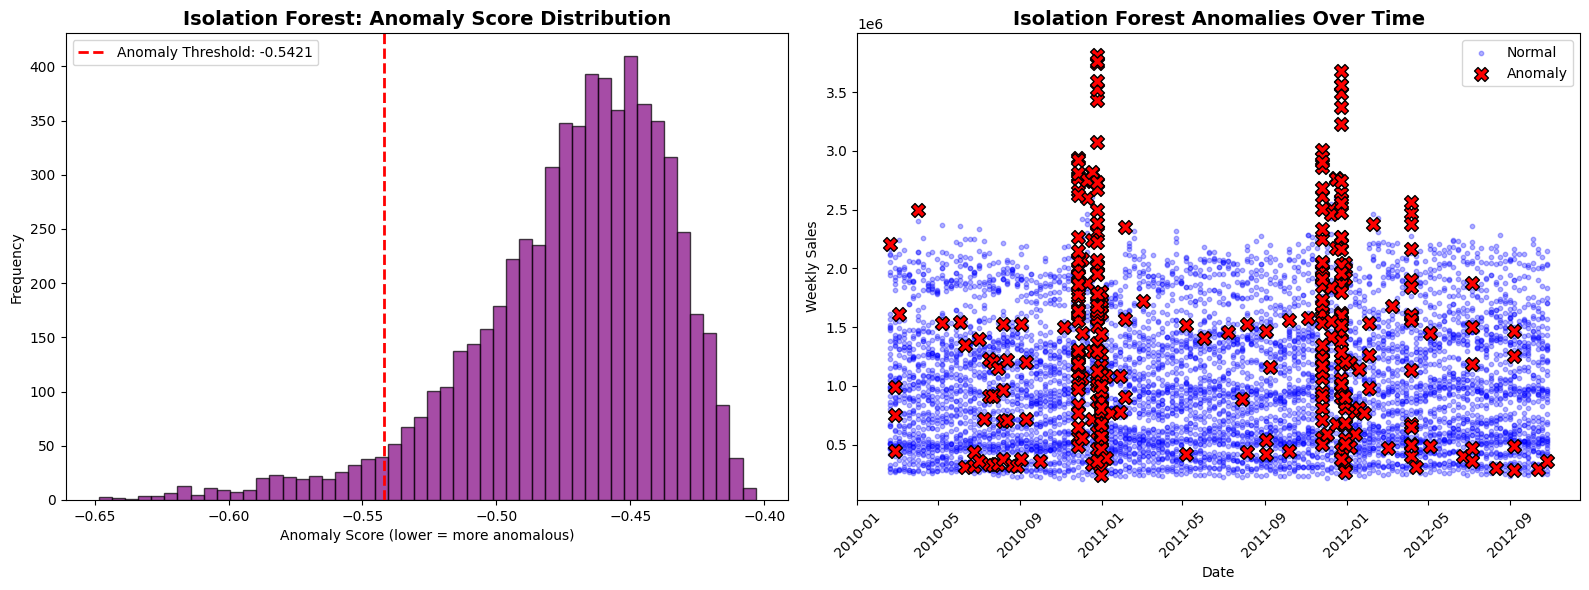

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Anomaly scores distribution
axes[0].hist(data['IsolationForest_Score'], bins=50, color='purple', edgecolor='black', alpha=0.7)
threshold = data[data['IsolationForest_Anomaly'] == 1]['IsolationForest_Score'].max()
axes[0].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold: {threshold:.4f}')
axes[0].set_title('Isolation Forest: Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Anomaly Score (lower = more anomalous)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Anomalies over time
iso_anomalies = data[data['IsolationForest_Anomaly'] == 1]
axes[1].scatter(data['Date'], data['Weekly_Sales'], alpha=0.3, s=10, label='Normal', color='blue')
axes[1].scatter(iso_anomalies['Date'], iso_anomalies['Weekly_Sales'],
                color='red', s=100, marker='X', label='Anomaly', edgecolors='black', linewidths=1)
axes[1].set_title('Isolation Forest Anomalies Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weekly Sales')
axes[1].legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('isolation_forest_anomalies.png', dpi=300, bbox_inches='tight')
print("Isolation Forest visualizations saved as 'isolation_forest_anomalies.png'")
plt.show()

# Comparison

In [17]:
comparison = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical', 'Isolation Forest'],
    'Anomalies Detected': [
        data['KMeans_Anomaly'].sum(),
        data['Hierarchical_Anomaly'].sum(),
        data['IsolationForest_Anomaly'].sum()
    ],
    'Percentage': [
        f"{data['KMeans_Anomaly'].sum()/len(data)*100:.2f}%",
        f"{data['Hierarchical_Anomaly'].sum()/len(data)*100:.2f}%",
        f"{data['IsolationForest_Anomaly'].sum()/len(data)*100:.2f}%"
    ]
})

print("\n" + comparison.to_string(index=False))

# Consensus anomalies (detected by at least 2 methods)
data['Consensus_Anomaly'] = (
    (data['KMeans_Anomaly'] + data['Hierarchical_Anomaly'] + data['IsolationForest_Anomaly']) >= 2
).astype(int)

print(f"\nConsensus anomalies (detected by ≥2 methods): {data['Consensus_Anomaly'].sum()}")


          Method  Anomalies Detected Percentage
         K-Means                 318      5.01%
    Hierarchical                  82      1.29%
Isolation Forest                 318      5.01%

Consensus anomalies (detected by ≥2 methods): 180



Method comparison saved as 'method_comparison.png'


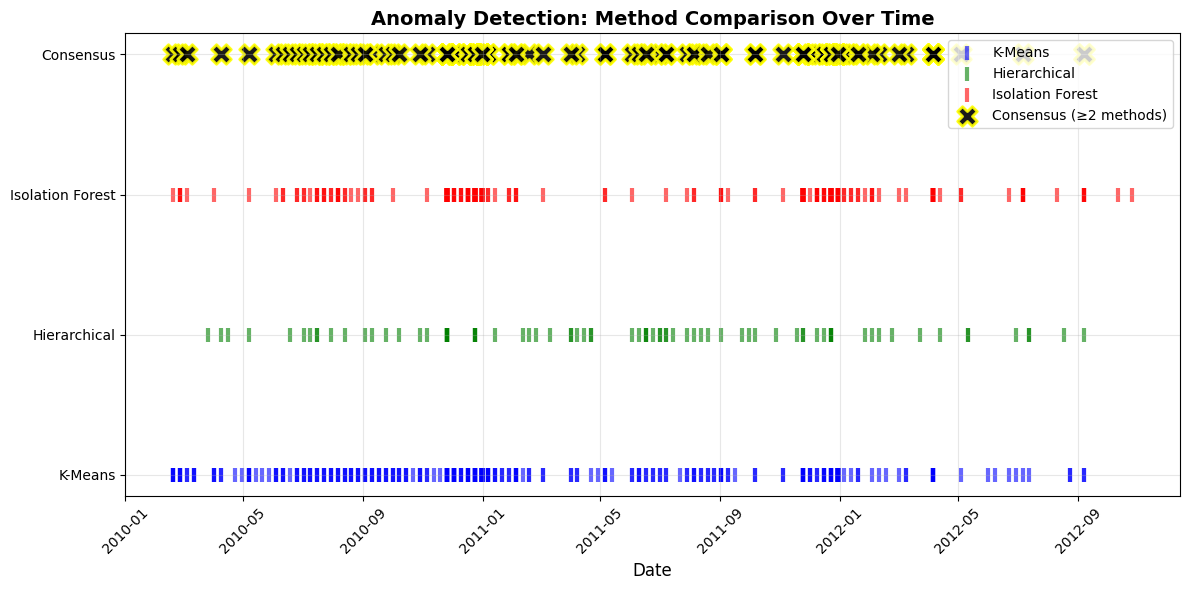

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

methods = ['K-Means', 'Hierarchical', 'Isolation Forest']
colors = ['blue', 'green', 'red']

for i, (method, color) in enumerate(zip(methods, colors)):
    col_name = f'{method.replace(" ", "").replace("-", "")}_Anomaly'
    anomaly_dates = data[data[col_name] == 1]['Date']
    ax.scatter(anomaly_dates, [i] * len(anomaly_dates), 
               alpha=0.6, s=100, c=color, label=method, marker='|', linewidths=3)

# Consensus anomalies
consensus_dates = data[data['Consensus_Anomaly'] == 1]['Date']
ax.scatter(consensus_dates, [3] * len(consensus_dates),
           alpha=0.9, s=200, c='black', label='Consensus (≥2 methods)', marker='X', edgecolors='yellow', linewidths=2)

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['K-Means', 'Hierarchical', 'Isolation Forest', 'Consensus'])
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Anomaly Detection: Method Comparison Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
print("\nMethod comparison saved as 'method_comparison.png'")
plt.show()

# Detailed Anomaly Analysis

In [19]:
consensus_anomalies = data[data['Consensus_Anomaly'] == 1].sort_values('Weekly_Sales', ascending=False)

print(f"\nTop 10 Consensus Anomalies:")
print(consensus_anomalies[['Date', 'Store', 'Weekly_Sales', 'Holiday_Flag', 
                           'Sales_Deviation', 'Sales_WoW_Change']].head(10).to_string(index=False))

# Categorize anomalies
data['Anomaly_Type'] = 'Normal'
data.loc[data['Sales_Deviation'] > 3, 'Anomaly_Type'] = 'Unusually High Sales'
data.loc[data['Sales_Deviation'] < -3, 'Anomaly_Type'] = 'Unusually Low Sales'
data.loc[data['Sales_WoW_Change'] > 0.5, 'Anomaly_Type'] = 'Sudden Spike'
data.loc[data['Sales_WoW_Change'] < -0.5, 'Anomaly_Type'] = 'Sudden Drop'

anomaly_types = data[data['Anomaly_Type'] != 'Normal']['Anomaly_Type'].value_counts()
print("\nAnomaly Type Distribution:")
print(anomaly_types)


Top 10 Consensus Anomalies:
      Date  Store  Weekly_Sales  Holiday_Flag  Sales_Deviation  Sales_WoW_Change
2010-12-24     14    3818686.45             0         1.424879          0.382149
2010-12-24     20    3766687.43             0         1.428862          0.336087
2010-12-24     10    3749057.69             0         1.404592          0.333403
2011-12-23      4    3676388.98             0         1.389737          0.326547
2010-12-24     13    3595903.20             0         1.348860          0.297389
2011-12-23     13    3556766.03             0         1.334285          0.288521
2011-12-23     20    3555371.03             0         1.405908          0.286865
2010-12-24      4    3526713.39             0         1.360132          0.287095
2011-12-23     10    3487986.89             0         1.409978          0.365145
2010-12-24      2    3436007.68             0         1.371189          0.316898

Anomaly Type Distribution:
Anomaly_Type
Sudden Spike    39
Sudden Drop     22
N


✓ Anomaly types visualization saved as 'anomaly_types.png'


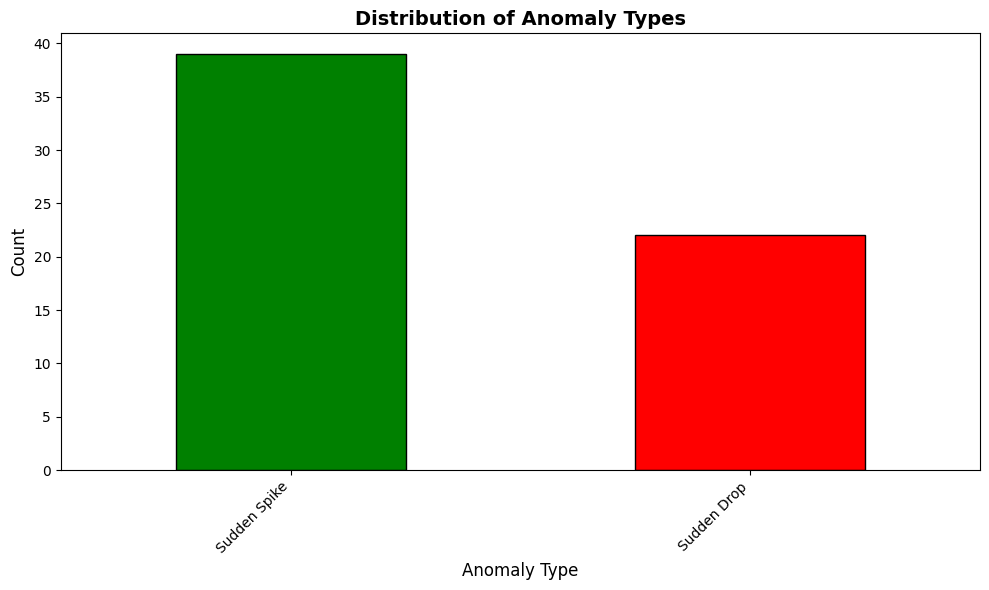

In [20]:
plt.figure(figsize=(10, 6))
anomaly_types.plot(kind='bar', color=['green', 'red', 'orange', 'purple'], edgecolor='black')
plt.title('Distribution of Anomaly Types', fontsize=14, fontweight='bold')
plt.xlabel('Anomaly Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('anomaly_types.png', dpi=300, bbox_inches='tight')
print("\n✓ Anomaly types visualization saved as 'anomaly_types.png'")
plt.show()

# Save Models and Results

In [21]:
with open('kmeans_anomaly_model.pkl', 'wb') as f:
    pickle.dump({'model': kmeans, 'scaler': scaler_kmeans, 'threshold': kmeans_threshold}, f)

with open('isolation_forest_model.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)

print("Models saved:")
print("  - kmeans_anomaly_model.pkl")
print("  - isolation_forest_model.pkl")

# Save anomaly data
anomaly_results = data[['Date', 'Store', 'Weekly_Sales', 'Holiday_Flag',
                        'KMeans_Anomaly', 'Hierarchical_Anomaly', 'IsolationForest_Anomaly',
                        'Consensus_Anomaly', 'Anomaly_Type', 'Sales_Deviation']].copy()

anomaly_results.to_csv('anomaly_detection_results.csv', index=False)
print("Results saved: anomaly_detection_results.csv")

# Export consensus anomalies for business review
consensus_export = anomaly_results[anomaly_results['Consensus_Anomaly'] == 1].copy()
consensus_export.to_csv('critical_anomalies.csv', index=False)
print(f"Critical anomalies exported: critical_anomalies.csv ({len(consensus_export)} records)")

Models saved:
  - kmeans_anomaly_model.pkl
  - isolation_forest_model.pkl
Results saved: anomaly_detection_results.csv
Critical anomalies exported: critical_anomalies.csv (180 records)
